In [35]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as mlt
import seaborn as sp
from torch.autograd import Variable
from torch import autograd
from datetime import datetime
import matplotlib.pyplot as plt
from datetime import timedelta
import sys
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from scipy.stats import ks_2samp
from statsmodels.graphics.tsaplots import plot_acf

In [36]:
# boulder - https://open-data.bouldercolorado.gov/datasets/95992b3938be4622b07f0b05eba95d4c_0/explore
# Palo alto - https://data.cityofpaloalto.org/dataviews/241685/electric-vehicle-charging-station-usage-fy-2011-fy-2017/
# Dunde - https://github.com/yvenn-amara/ev-load-open-data/tree/master/1.%20Input%20Data/1.%20Dundee
# Perth - https://data.pkc.gov.uk/search?groupIds=03913ed5717b4e90babe7f88f89fe56a&q=charging
# Caltech - https://ev.caltech.edu/dataset
# jpl - https://ev.caltech.edu/dataset
# Office - https://ev.caltech.edu/dataset

In [37]:
%run Pre_process/Data_preprocess.ipynb

In [3]:
pre_process_dataset("./Data/Raw/office.csv", 'office')

In [38]:
def hourly_consumption_visualize(df, path):
    dataset_weekday = df[df['Week Day'] == 1]
    dataset_weekend = df[df['Week Day'] == 0]
    average_values_weekdays = dataset_weekday.groupby(pd.to_datetime(df['Start']).dt.hour)['Energy'].mean().reset_index(name='Energy')
    average_values_weekend = dataset_weekend.groupby(pd.to_datetime(df['Start']).dt.hour)['Energy'].mean().reset_index(name='Energy')
    mlt.figure(figsize=(10, 6))
    mlt.xlabel('Hours in a day')
    mlt.ylabel('Average Energy Consumption in Kwh')
    mlt.plot(average_values_weekdays['Energy'], label='Open days')
    mlt.plot(average_values_weekend['Energy'], label='Weekend days')
    mlt.legend()
    mlt.savefig(path)
    mlt.show()

In [55]:
def weekdays_consumption_visualize(df, path):
    weekday_data = df[df['Day of week'] <= 5]

    # Initialize an empty list to store average values
    average_per_weekday = []

    # Initialize an empty list to store the corresponding weekday names
    weekday_names = []

    # Iterate through each weekday
    for weekday in range(0, 5):  # Only consider weekdays (Monday to Friday)
        # Filter data for the current weekday
        current_weekday_data = weekday_data[weekday_data['Day of week'] == weekday + 1]
        
        # Check if there are observations for the current weekday
        if not current_weekday_data.empty:
            #hourly_grouped = current_weekday_data.groupby([pd.to_datetime(current_weekday_data['Start']).dt.year, current_weekday_data['Month'], current_weekday_data['Day of month']])['Energy'].sum().reset_index(name='Energy')
            # Calculate the average for the current weekday
            average_value = current_weekday_data['Energy'].mean()
                
            # Append the average to the list
            average_per_weekday.append(average_value)
            
            # Append the corresponding weekday name to the list
            weekday_names.append(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'][weekday])

    # Plotting
    fig, ax = plt.subplots()
    bars = ax.bar(weekday_names, average_per_weekday)
    mlt.title('Average per hour energy consumption on Weekdays')
    mlt.xlabel('Weekday')
    mlt.ylabel('Average energy consumption')

    # Add average values on top of the bars
    for bar, value in zip(bars, average_per_weekday):
        ax.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.1, f'{value:.4f}', fontsize=9)

    mlt.savefig(path)
    mlt.show()


In [169]:
def weekenddays_consumption_visualize(df, path):
    weekend_data = df[df['Day of week'].isin([6, 7])]

    # Initialize an empty list to store average values
    average_per_weekend_day = []

    # Iterate through each weekend day
    for day in [6, 7]:  # Saturday and Sunday
        # Filter data for the current weekend day
        current_weekend_data = weekend_data[weekend_data['Day of week'] == day]
        
        # Check if there are observations for the current weekend day
        if not current_weekend_data.empty:
            # hourly_grouped = current_weekend_data.groupby([pd.to_datetime(current_weekend_data['Start']).dt.year, current_weekend_data['Month'], current_weekend_data['Day of month']])['Energy'].sum().reset_index(name='Energy')
            # # Calculate the average for the current weekend day
            # average_value = hourly_grouped['Energy'].mean()
            
            # # Append the average to the list
            # average_per_weekend_day.append(average_value)
            # Calculate the average for the current weekend day
            average_value = current_weekend_data['Energy'].mean()
            
            # Append the average to the list
            average_per_weekend_day.append(average_value)

    # Plotting
    fig, ax = plt.subplots()
    bars = ax.bar(['Saturday', 'Sunday'], average_per_weekend_day)
    mlt.title('Average per hour energy consumptions on Weekends')
    mlt.xlabel('Weekend Day')
    mlt.ylabel('Average Energy Consumption')

    # Add average values on top of the bars
    for bar, value in zip(bars, average_per_weekend_day):
        ax.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height(), f'{value:.4f}', fontsize=9)

    mlt.savefig(path)
    mlt.show()

In [170]:
def monthly_consumption(df, path, dataset_type):
    df['Hour'] = pd.to_datetime(df['Start']).dt.hour
    hourly_grouped = df.groupby([pd.to_datetime(df['Start']).dt.year, df['Month'], df['Day of month']])['Hour'].count().reset_index(name='Hour')
    day_grouped = hourly_grouped.groupby([hourly_grouped['Start'], hourly_grouped['Month']])['Day of month'].count().reset_index(name='Day of Month')
    average_values_weekdays = df.groupby([pd.to_datetime(df['Start']).dt.year, df['Month']])['Energy'].sum().reset_index(name='Energy')
    average_values_weekdays.loc[:,'Energy'] = average_values_weekdays['Energy'] // day_grouped['Day of Month']
    #average_values_weekdays = df.groupby([pd.to_datetime(df['Start']).dt.year, df['Month']])['Energy'].mean().reset_index(name='Energy')
    month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
    average_values_weekdays['Month_Name'] = average_values_weekdays['Month'].map(month_names)

    # Combine 'Month_Name' and 'Start' columns to create 'Month-Year' column
    average_values_weekdays['Month-Year'] = average_values_weekdays['Month_Name'] + '-' + average_values_weekdays['Start'].astype(str)
    average_values_weekdays.to_csv('Data/Processed/Monthly/' + dataset_type + '_monthly.csv', index=False)
    mlt.figure(figsize=(20, 10))
    mlt.suptitle('Average energy consumption per month')
    mlt.ylabel('Average Energy Consumption in Kwh')
    mlt.plot(average_values_weekdays['Month-Year'], average_values_weekdays['Energy'], label='real', marker='o')
    mlt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate x-axis labels for better visibility
    #mlt.xticks(average_values_weekdays['Month-Year'].iloc[::2])
    mlt.legend()
    mlt.savefig(path)
    mlt.show()

In [171]:
dataset = 'jpl'

In [172]:
# data1 = pd.read_csv("Data/Processed/sap_data_with_zero.csv")
# data2 = pd.read_csv("Data/Processed/palo_alto_data_with_zero.csv")
# data3 = pd.read_csv("Data/Processed/boulder_data_with_zero.csv")
# data1 = data1.loc[(data1['Start'] >= '2019-01-01 00:00:00') & (data1['Start'] <= '2019-12-31 23:00:00')]
# data2 = data2.loc[(data2['Start'] >= '2017-01-01 00:00:00') & (data2['Start'] <= '2018-01-01 23:00:00')]
# data3 = data3.loc[(data3['Start'] >= '2018-01-02 00:00:00') & (data3['Start'] <= '2018-12-31 23:00:00')]
# df = pd.concat([data2, data3, data1], axis=0).reset_index(drop=True)
# df['Sum'] = df.groupby(pd.to_datetime(df['Start']).dt.date)['Energy'].cumsum()
# df.drop(columns=['Start'], inplace=True)
# input_size = df.shape[1]
# df['Sum'] = df.groupby(pd.to_datetime(df['Start']).dt.date)['Energy'].cumsum()
# df.drop(columns=['Start'], inplace=True)
df = pd.read_csv('Data/Processed/' + dataset + '_data_with_zero.csv')
#df = df[(df['Year'] >= 2018) & (df['Year'] <= 2021)].reset_index(drop=True)

In [173]:
df.head()

,Start,Day of week,Energy,Week Day,Year,Month,Day of month
0,2018-10-08 06:00:00,1,2.369930,1,2018,10,8
1,2018-10-08 07:00:00,1,14.701857,1,2018,10,8
2,2018-10-08 08:00:00,1,23.415985,1,2018,10,8
3,2018-10-08 09:00:00,1,23.415985,1,2018,10,8
4,2018-10-08 10:00:00,1,23.415985,1,2018,10,8


In [174]:
df.tail()

,Start,Day of week,Energy,Week Day,Year,Month,Day of month
22018,2021-04-12 16:00:00,1,8.524886,1,2021,4,12
22019,2021-04-12 17:00:00,1,3.473757,1,2021,4,12
22020,2021-04-12 18:00:00,1,3.473757,1,2021,4,12
22021,2021-04-12 19:00:00,1,3.473757,1,2021,4,12
22022,2021-04-12 20:00:00,1,1.028618,1,2021,4,12


In [175]:
df.describe()

,Day of week,Energy,Week Day,Year,Month,Day of month
count,22023.000000,22023.000000,22023.000000,22023.000000,22023.000000,22023.000000
mean,3.997957,13.861879,0.714480,2019.528538,6.465604,15.699768
std,2.000896,26.608068,0.451672,0.809921,3.689803,8.787956
min,1.000000,0.000000,0.000000,2018.000000,1.000000,1.000000
25%,2.000000,0.000000,0.000000,2019.000000,3.000000,8.000000
50%,4.000000,0.000000,1.000000,2020.000000,6.000000,16.000000
75%,6.000000,14.020963,1.000000,2020.000000,10.000000,23.000000
max,7.000000,155.879145,1.000000,2021.000000,12.000000,31.000000


In [176]:
(df[df['Energy'] == 0].shape[0] * 100) // df.shape[0]

51

In [177]:
df.tail()

,Start,Day of week,Energy,Week Day,Year,Month,Day of month
22018,2021-04-12 16:00:00,1,8.524886,1,2021,4,12
22019,2021-04-12 17:00:00,1,3.473757,1,2021,4,12
22020,2021-04-12 18:00:00,1,3.473757,1,2021,4,12
22021,2021-04-12 19:00:00,1,3.473757,1,2021,4,12
22022,2021-04-12 20:00:00,1,1.028618,1,2021,4,12


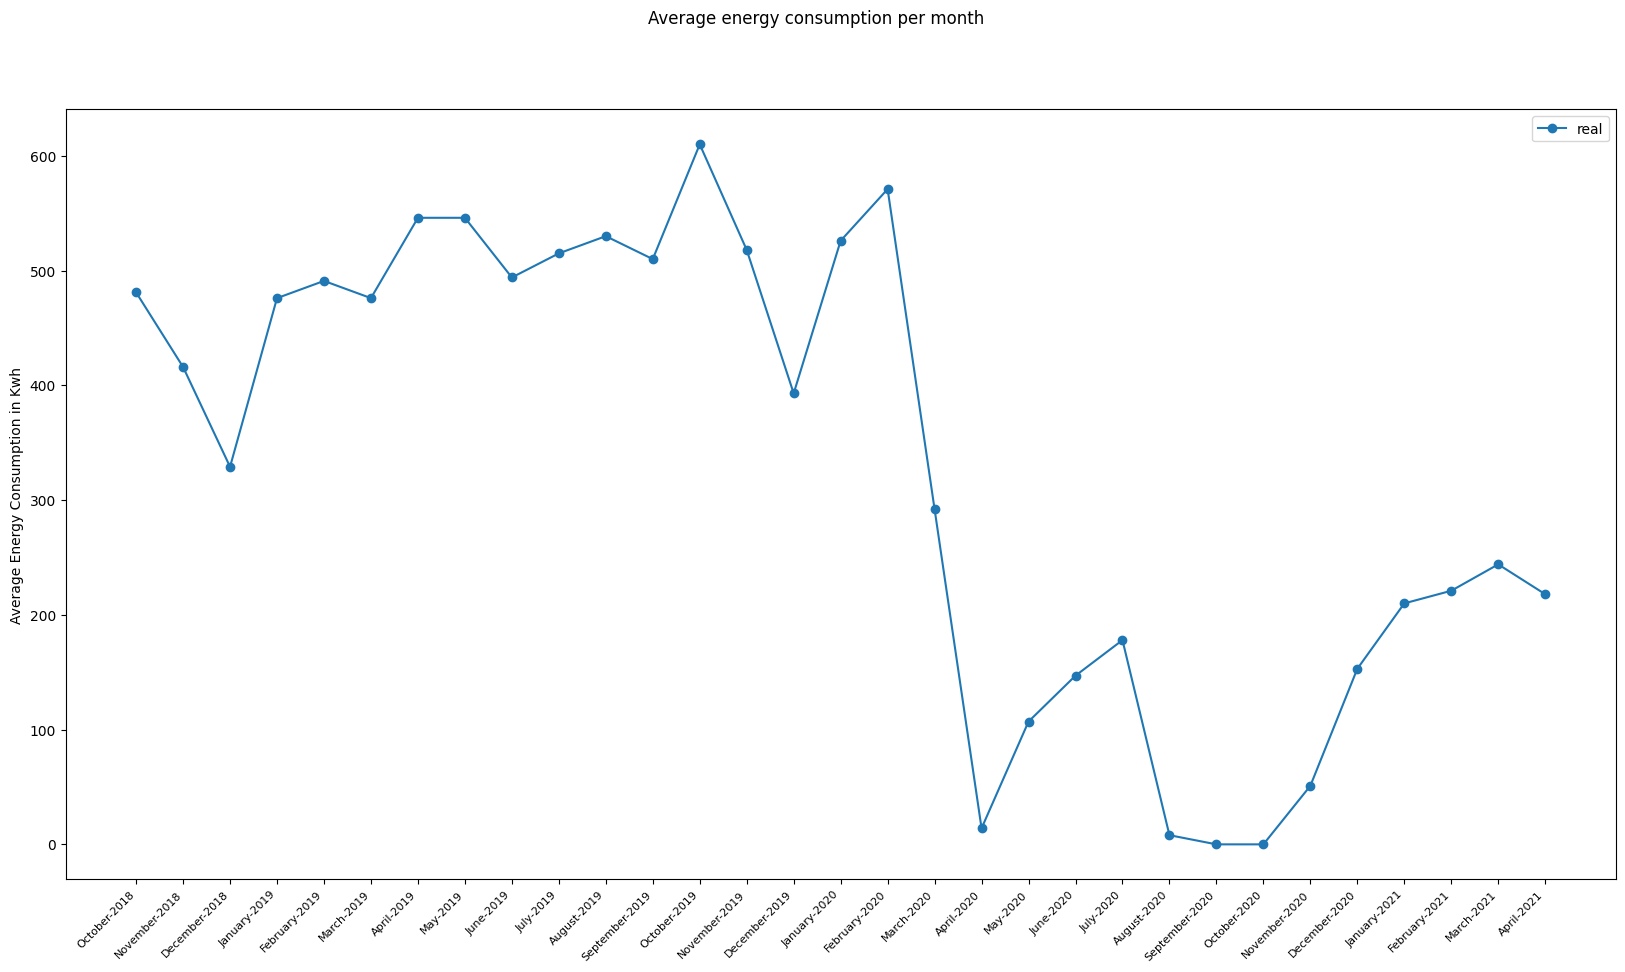

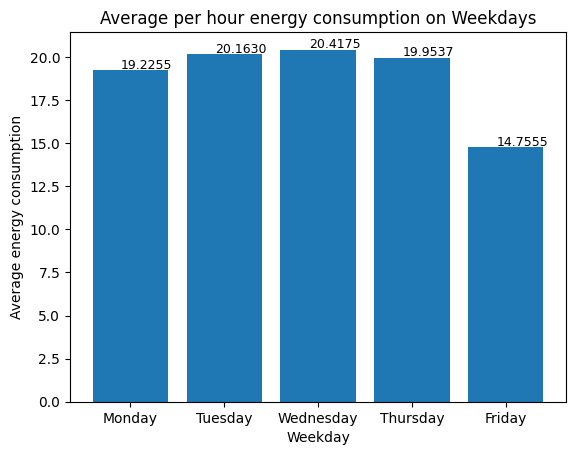

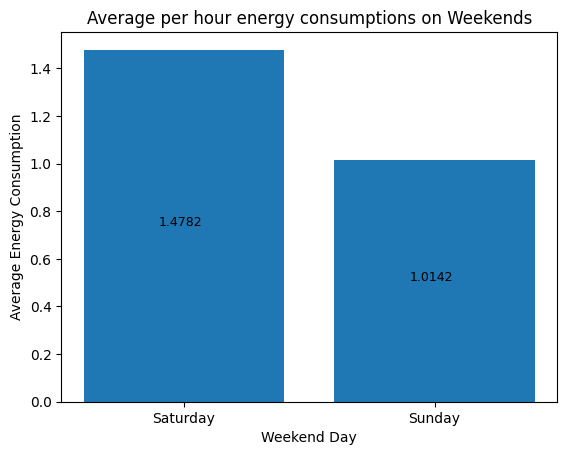

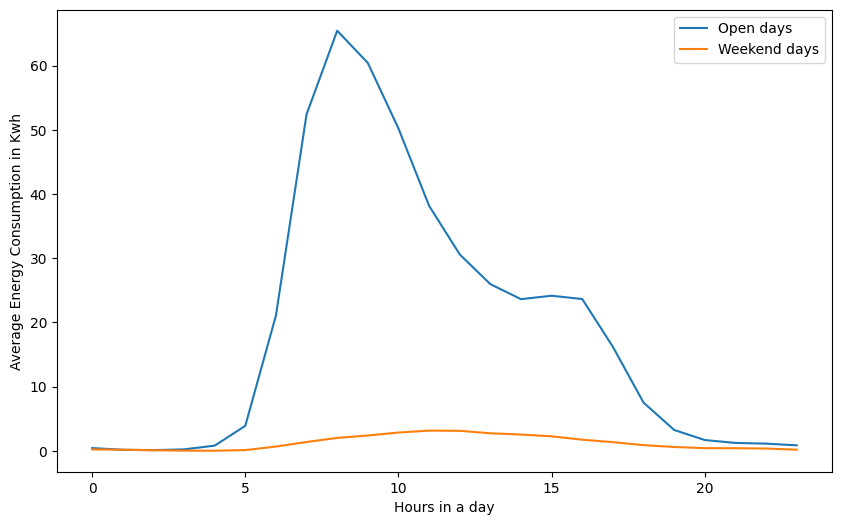

In [178]:
monthly_consumption(df, 'EDA/' + dataset + '_monthly', dataset)
weekdays_consumption_visualize(df, 'EDA/' + dataset + '_weekly')
weekenddays_consumption_visualize(df, 'EDA/' + dataset + '_weekend')
hourly_consumption_visualize(df, 'EDA/' + dataset + '_hourly', )

In [150]:
df = pd.read_csv('Data/Processed/Monthly/caltech_monthly.csv')
df2 = pd.read_csv('Data/Processed/Monthly/jpl_monthly.csv')
df3 = pd.read_csv('Data/Processed/Monthly/office_monthly.csv')
df4 = pd.read_csv('Data/Processed/Monthly/acn_monthly.csv')
# df5 = pd.read_csv('Data/Processed/Monthly/caltech_monthly.csv')
# df6 = pd.read_csv('Data/Processed/Monthly/perth_monthly.csv')
# df7 = pd.read_csv('Data/Processed/Monthly/dundee_monthly.csv')
mlt.figure(figsize=(20, 6))
mlt.suptitle('Average energy consumption per month')
mlt.ylabel('Average Energy Consumption in Kwh')
mlt.plot(df2['Month-Year'], df2['Energy'], label='JPL', marker='o')
mlt.plot(df['Month-Year'], df['Energy'], label='Caltech', marker='*')
mlt.plot(df3['Month-Year'], df3['Energy'], label='Office', marker='o')
mlt.plot(df4['Month-Year'], df4['Energy'], label='ACN', marker='o')
# mlt.plot(df5['Month-Year'], df5['Energy'], label='Caltech', marker='o')
# mlt.plot(df6['Month-Year'], df6['Energy'], label='Perth', marker='o')
#mlt.plot(df7['Month-Year'], df7['Energy'], label='Dundee', marker='o')
mlt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate x-axis labels for better visibility
#mlt.xticks(average_values_weekdays['Month-Year'].iloc[::2])
mlt.legend()
#mlt.savefig('EDA/all_dataset_monthly_comaprision')
mlt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Data/Processed/Monthly/jpl_monthly.csv'

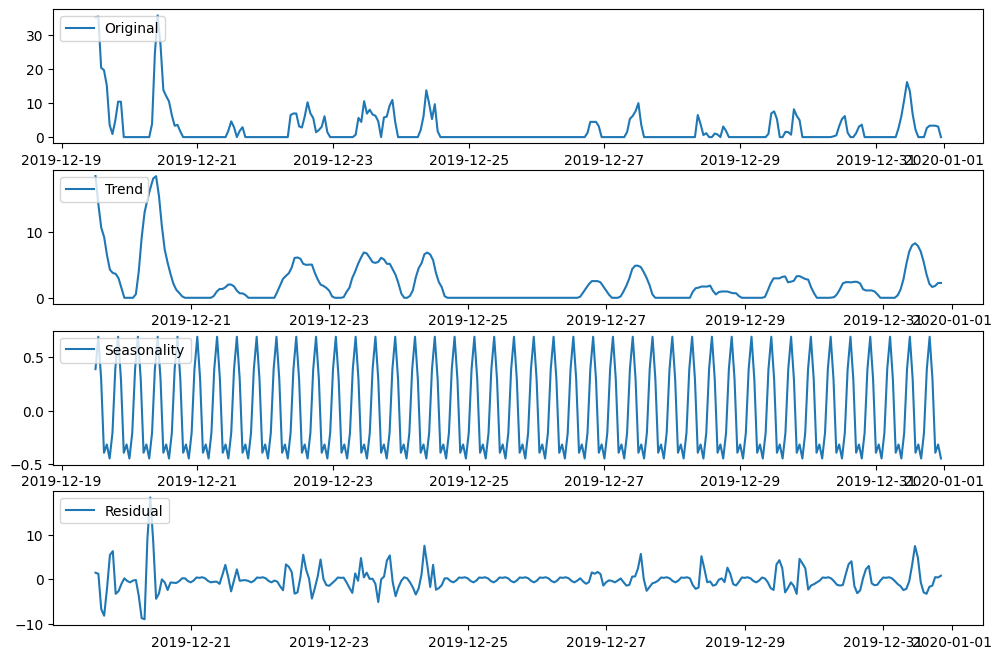

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load your time series data into a Pandas DataFrame
# Assuming your dataset has a column 'timestamp' and 'value'
# Replace 'your_dataset.csv' with the actual filename
data1 = pd.read_csv("Data/Processed/caltech_data_with_zero.csv")
data2 = pd.read_csv("Data/Processed/palo_alto_data_with_zero.csv")
data3 = pd.read_csv("Data/Processed/boulder_data_with_zero.csv")
data1 = data1.loc[(data1['Start'] >= '2019-01-01 00:00:00') & (data1['Start'] <= '2019-12-31 23:00:00')]
data2 = data2.loc[(data2['Start'] >= '2017-01-01 00:00:00') & (data2['Start'] <= '2018-01-01 23:00:00')]
data3 = data3.loc[(data3['Start'] >= '2018-01-02 00:00:00') & (data3['Start'] <= '2018-12-31 23:00:00')]
df = pd.concat([data2, data3, data1], axis=0).reset_index(drop=True).tail(300)
df['Sum'] = df.groupby(pd.to_datetime(df['Start']).dt.date)['Energy'].cumsum()
#df = pd.read_csv('Data/Processed/boulder_data_with_zero.csv').head(300)
df['Start'] = pd.to_datetime(df['Start'])
df.set_index('Start', inplace=True)

# Decompose the time series to get the seasonality component
result = seasonal_decompose(df['Energy'], model='additive', period=7)

# Access the seasonality component
seasonality_matrix = result.seasonal.dropna()

# Plot the original time series, trend, and seasonality
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(df['Energy'], label='Original')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonality')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')

plt.show()


In [79]:
data1 = pd.read_csv("Data/Processed/palo_alto_data_with_zero.csv")

In [80]:
data1.tail()

,Start,Day of week,Energy,Week Day,Year,Month,Day of month
82629,2020-12-31 17:00:00,4,8.127153,1,2020,12,31
82630,2020-12-31 18:00:00,4,10.321537,1,2020,12,31
82631,2020-12-31 19:00:00,4,3.298768,1,2020,12,31
82632,2020-12-31 20:00:00,4,3.074711,1,2020,12,31
82633,2020-12-31 21:00:00,4,2.188169,1,2020,12,31


In [28]:
data1 = data1.sort_values(by='Energy')

In [31]:
data1.describe()

,Day of week,Energy,Week Day,Year,Month,Day of month
count,28440.000000,28440.000000,28440.000000,28440.000000,28440.000000,28440.000000
mean,3.997468,5.112840,0.714768,2019.153586,6.183122,15.729958
std,1.999401,6.803374,0.451533,0.946717,3.530910,8.788216
min,1.000000,0.000000,0.000000,2018.000000,1.000000,1.000000
25%,2.000000,0.000000,0.000000,2018.000000,3.000000,8.000000
50%,4.000000,2.139464,1.000000,2019.000000,6.000000,16.000000
75%,6.000000,8.291419,1.000000,2020.000000,9.000000,23.000000
max,7.000000,53.699695,1.000000,2021.000000,12.000000,31.000000
